In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # 모델 성능 평가 라이브러리


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam   # 최적화 모델

import matplotlib.pyplot as plt

2025-04-20 23:25:20.631760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 23:25:20.632410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 23:25:20.636044: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 23:25:20.646263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745159120.665011 2313009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745159120.66

In [2]:
# titanic 데이터 전처리 함수
def data_preprocessed(df):

    ## === Name의 호칭 추출 ===
    _splitted = []

    # 호칭(Mr., Mrs., Miss. 등)의 따른 결과에 차이를 고려하여, 해당 호칭을 새로운 column으로 생성
    for i in range(0, df['Name'].count()):
        # 우선적으로 이름 분리
        # 분리된 뒷 이름(index: 1)을 공백으로 분리하고 가장 처음(index: 0)이 호칭이므로, 그 값을 _splitted에 저장
        _splitted.append(((df['Name'][i].split(sep=', ')[-1]).split(sep=' '))[0])

    # 새로운 column 'Title_Name'에 저장
    df['Title_Name'] = _splitted


    ## === Ticket의 첫 이니셜 생성 ===
    df['Ticket'].astype(str)

    """
    for i in range(0, df['Ticket'].count()):
        # 임시로 분할된 티켓 이름
        _splitted = df['Ticket'][i].split(sep=' ')
        print(_splitted)
        if (len(_splitted) == 1):
            df['Ticket'][i] = 0
    """

    df['Ticket_First'] = df['Ticket'].astype(str).str[:1]

    # x_data에 대한 결측치 처리 (평균 처리)
    df['Age'] = df['Age'].fillna(np.mean(df['Age']))


    df = df.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'])

    # 처리되지 않은 결측치 확인 및 해당 Row 제거 (row: 152)
    missing_indices = df[df.isna().any(axis=1)].index
    df = df.drop(index=missing_indices)

    # One-Hot-Encoding (column: 'Pclass', 'Sex', 'Title_Name', 'Ticket_First', 'Embarked') + ('Ticket_First')
    df = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Title_Name', 'Ticket_First', 'Embarked']).astype(float)

    # x_data, y_data 분리
    y_data = df['Survived'].astype(float)
    x_data = df.drop(columns=['Survived'])

    # 정규화 함수 정의
    scaler = MinMaxScaler(feature_range=(0, 1))

    # x_data 정규화 (y_data는 0과 1이니까, 정규화 할 필요가 없지 않을까?)
    x_data = scaler.fit_transform(x_data)
    
    return x_data, y_data

In [3]:
# 모델 평가치 저장 리스트
model_history = []

In [4]:
## 모델 1

# 데이터 호출 및 전처리
df = pd.read_csv("./data/titanic.csv")
x_data, y_data = data_preprocessed(df)

# 데이터 분할 (train, test)
x_train, x_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.3,
    random_state=42,
)

# 모델 1 구성
def model_1():
    model = Sequential()

    # 은닉층: Relu, 출력층: sigmoid
    print(f"imput_dim: {x_data.shape[1]}")  # input_dim: x_data의 열의 수 (1번 인덱스)
    model.add(Dense(1, input_dim=x_data.shape[1], activation='sigmoid'))

    # 최적화 모델 설정
    optimizer = SGD(learning_rate=0.001)

    model.summary()

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# 모델 1 불러오기
model = model_1()

history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=8,
    verbose=1
)

# model 평가
score = model.evaluate(x_test, y_test)

# 모델의 accuray, loss 기록 값 저장
model_history.append({
    "id": 1,
    "accuracy": history.history['accuracy'],
    "loss": history.history['loss'],
})

imput_dim: 35


/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-20 23:25:22.309672: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 36 (144.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1489 - loss: 0.9112  
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1712 - loss: 0.8860 
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1864 - loss: 0.8654 
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1687 - loss: 0.8582 
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1714 - loss: 0.8432 
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2455 - loss: 0.8296 
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2272 - loss: 0.8277 
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2734 - loss: 0.8196 
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3557 - loss: 0.7835 
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3227 - loss: 0.7844 
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3441 - loss: 0.7669 
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [5]:
## 모델 2

# 데이터 호출 및 전처리
df = pd.read_csv("./data/titanic.csv")
x_data, y_data = data_preprocessed(df)

# 데이터 분할 (train, test)
x_train, x_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.3,
    random_state=42,
)

# train_data 데이터 분할 (train, validation)
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.125,
    random_state=42,
)

# 모델 2 구성
def model_2():
    model = Sequential()

    # 은닉층: Relu, 출력층: sigmoid
    print(f"imput_dim: {x_data.shape[1]}")  # input_dim: x_data의 열의 수 (1번 인덱스)
    model.add(Dense(32, input_dim=x_data.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # 최적화 모델 설정
    optimizer = SGD(learning_rate=0.001)

    model.summary()

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# 모델 2 불러오기
model = model_2()

history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=8,
    validation_data=(x_val, y_val),
    verbose=1
)

# model 평가
score = model.evaluate(x_test, y_test)

# 모델의 accuray, loss 기록 값 저장
model_history.append({
    "id": 2,
    "accuracy": history.history['accuracy'],
    "loss": history.history['loss'],
})

imput_dim: 35


/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4055 - loss: 0.7220 - val_accuracy: 0.5135 - val_loss: 0.7065
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4756 - loss: 0.7055 - val_accuracy: 0.4865 - val_loss: 0.6993
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4570 - loss: 0.7075 - val_accuracy: 0.5405 - val_loss: 0.6925
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5312 - loss: 0.6918 - val_accuracy: 0.7027 - val_loss: 0.6860
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6640 - loss: 0.6878 - val_accuracy: 0.7297 - val_loss: 0.6799
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6864 - loss: 0.6826 - val_accuracy: 0.7297 - val_loss: 0.6740
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 0.6744 - val_accuracy: 0.7568 - val_loss: 0.6684
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6997 - loss: 0.6715 - val_accuracy: 0.7568 - v

In [6]:
## 모델 3

# 데이터 호출 및 전처리
df = pd.read_csv("./data/titanic.csv")
x_data, y_data = data_preprocessed(df)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5개의 폴드로 나누기

def model_3():
    # 밖에 모델을 설정하더라도, 계속 재사용 가능함
    model = Sequential([
        Dense(32, input_dim=x_data.shape[1]),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),

        Dense(16),
        BatchNormalization(),
        Activation('relu'),

        Dense(1, activation='sigmoid')
    ])

    # 최적화 모델 설정
    optimizer = SGD(learning_rate=0.001)

    # 모델 컴파일
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model



kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5개의 폴드로 나누기

# 평가 저장용 리스트
accuracies = [] #정확도 평가
precisions = [] #정밀도 평가
recalls = []    #재현율 평가
f1_scores = []  #조화 평균?

# 각 폴드 시행 별 해당 폴드의 accuray와 lose의 epoch 당 기록을 저장할 리스트
kfold_accuray = []
kfold_loss = []

for train_index, val_index in kf.split(x_data):

    # 훈련과 검증 데이터 분리
    x_train, x_val = pd.DataFrame(x_data).iloc[train_index], pd.DataFrame(x_data).iloc[val_index]
    y_train, y_val = pd.DataFrame(y_data).iloc[train_index], pd.DataFrame(y_data).iloc[val_index]

    # 모델 3 불러오기
    model = model_3()

    # 모델 훈련
    history = model.fit(
        x_train, 
        y_train,
        epochs=100, 
        batch_size=32,
        validation_data=(x_val, y_val), 
        verbose=1
    )
    y_pred = (model.predict(x_val) > 0.5).astype(int)

    # 모델 성능 평가
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    kfold_accuray.append(history.history['accuracy'])
    kfold_loss.append(history.history['loss'])

def print_avg():
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f1 = np.mean(f1_scores)

    print(f"\n모델 평균 성능:")
    print(f"평균 정확도: {avg_accuracy:.4f}")
    print(f"평균 Precision: {avg_precision:.4f}")
    print(f"평균 Recall: {avg_recall:.4f}")
    print(f"평균 F1-Score: {avg_f1:.4f}")

# 각 결과 값(accuracy, loss)을 DataFrame으로 변환하고, 각 열 별 평균값으로 변환
kfold_accuray = pd.DataFrame(kfold_accuray)
kfold_loss = pd.DataFrame(kfold_loss)

model_history.append({
    "id": 3,
    "accuracy": kfold_accuray.mean(),
    "loss": kfold_loss.mean()
})

# 평균 성능 출력
print_avg()

Epoch 1/100


/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6929 - loss: 0.6177 - val_accuracy: 0.7619 - val_loss: 0.6154
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7055 - loss: 0.6043 - val_accuracy: 0.7619 - val_loss: 0.6069
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7226 - loss: 0.5731 - val_accuracy: 0.7857 - val_loss: 0.5995
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7034 - loss: 0.6046 - val_accuracy: 0.7857 - val_loss: 0.5930
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7881 - loss: 0.5319 - val_accuracy: 0.8095 - val_loss: 0.5869
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7525 - loss: 0.5543 - val_accuracy: 0.8214 - val_loss: 0.5814
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7615 - loss: 0.5276 - val_accuracy: 0.8214 - val_loss: 0.5768
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7825 - loss: 0.5497 - val_accuracy: 0.8214 - val_loss: 0.

/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4336 - loss: 0.9349 - val_accuracy: 0.1786 - val_loss: 0.7366
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4788 - loss: 0.8605 - val_accuracy: 0.3810 - val_loss: 0.7301
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4621 - loss: 0.8805 - val_accuracy: 0.5238 - val_loss: 0.7236
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4466 - loss: 0.8896 - val_accuracy: 0.5595 - val_loss: 0.7162
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4417 - loss: 0.9018 - val_accuracy: 0.6310 - val_loss: 0.7090
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4425 - loss: 0.8656 - val_accuracy: 0.6310 - val_loss: 0.7019
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4419 - loss: 0.8619 - val_accuracy: 0.6310 - val_loss: 0.6953
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4933 - loss: 0.8614 - val_accuracy: 0.6310 - val_loss: 0.

/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3442 - loss: 1.0558 - val_accuracy: 0.4217 - val_loss: 0.8287
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3325 - loss: 1.0660 - val_accuracy: 0.5060 - val_loss: 0.8183
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3336 - loss: 1.0823 - val_accuracy: 0.5181 - val_loss: 0.8078
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4088 - loss: 1.0087 - val_accuracy: 0.5181 - val_loss: 0.7980
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3912 - loss: 1.0192 - val_accuracy: 0.5060 - val_loss: 0.7891
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3623 - loss: 1.0049 - val_accuracy: 0.5301 - val_loss: 0.7840
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4010 - loss: 0.9920 - val_accuracy: 0.5301 - val_loss: 0.7799
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3888 - loss: 0.9881 - val_accuracy: 0.5301 - val_loss: 0.

/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6429 - loss: 0.6389 - val_accuracy: 0.5663 - val_loss: 0.6749
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6750 - loss: 0.6245 - val_accuracy: 0.5783 - val_loss: 0.6651
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6375 - loss: 0.6533 - val_accuracy: 0.6386 - val_loss: 0.6568
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6731 - loss: 0.6498 - val_accuracy: 0.6386 - val_loss: 0.6496
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6499 - loss: 0.6467 - val_accuracy: 0.6627 - val_loss: 0.6433
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6916 - loss: 0.6218 - val_accuracy: 0.6627 - val_loss: 0.6382
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6383 - loss: 0.6324 - val_accuracy: 0.6867 - val_loss: 0.6326
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7015 - loss: 0.6067 - val_accuracy: 0.6867 - val_loss: 0.

/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5694 - loss: 0.8788 - val_accuracy: 0.6627 - val_loss: 0.6452
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5397 - loss: 0.8853 - val_accuracy: 0.6627 - val_loss: 0.6513
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6079 - loss: 0.7788 - val_accuracy: 0.6627 - val_loss: 0.6576
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5645 - loss: 0.8369 - val_accuracy: 0.6627 - val_loss: 0.6602
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5749 - loss: 0.8041 - val_accuracy: 0.6627 - val_loss: 0.6605
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6048 - loss: 0.7873 - val_accuracy: 0.6627 - val_loss: 0.6595
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5768 - loss: 0.8245 - val_accuracy: 0.6627 - val_loss: 0.6587
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6371 - loss: 0.7751 - val_accuracy: 0.6627 - val_loss: 0.

In [7]:
## 모델 앙상블 구축
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

# 학습 데이터 새로 불러오기
df = pd.read_csv("./data/titanic.csv")
x_data, y_data = data_preprocessed(df)

# 데이터 분할 (train, test)
x_train, x_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.3,
    random_state=42,
)

# Keras 식별모델로 래핑 (keras의 Sequential 모델을 직접적으로 앙상블 보팅 모델에 적용할 수 없다.)
model_1 = KerasClassifier(model=model_1, epochs=100, batch_size=8, verbose=0)
model_2 = KerasClassifier(model=model_2, epochs=100, batch_size=8, verbose=0)
model_3 = KerasClassifier(model=model_3, epochs=100, batch_size=8, verbose=0)

# 앙상블 모델 구성 (사전에 학습된 모델 3가지를 결합)
voting_model = VotingClassifier(
    estimators=[
        ('model_1', model_1),
        ('model_2', model_2),
        ('model_3', model_3),
    ],
    voting='hard'
)

voting_model.fit(x_train, y_train)

# voting_model의 history를 확인 (history는 모델을 fit 할 때마다 갱신됨)
# print(history)

# 모델의 accuray, loss 기록 값 저장
model_history.append({
    "id": 4,
    "accuracy": history.history['accuracy'],
    "loss": history.history['loss'],
})

imput_dim: 35


/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 1)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 36 (144.00 B)

 Non-trainable params: 0 (0.00 B)

imput_dim: 35


/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 32)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

/home/kimdowne/temp/HW5/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Figure size 640x480 with 0 Axes>

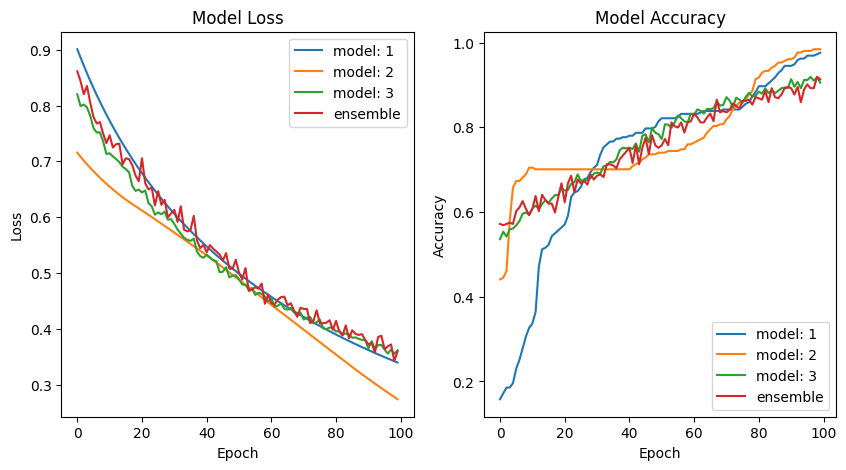

In [8]:
# 해당 모델의 결과 (loss, accuracy) 그래프로 나타내기
plt.clf()
plt.figure(figsize=(10,5))

# Loss 그래프
plt.subplot(121)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

for mh in model_history:           # 각 모델(id: 1, 2, 3)의 loss를 그래프에 그려냄
    plt.plot(mh['loss'])           # 앞서 fit()한 모델의 기록을 담은 history 변수의 'loss' 데이터
plt.legend(['model: 1', 'model: 2', 'model: 3', 'ensemble'], loc='upper right')    # 해당 곡선(요소)에 대한 설명


# Accuracy 그래프
plt.subplot(122)
plt.title('Model Accuracy')     # 앞서 fit()한 모델의 기록을 담은 history 변수의 'accuracy' 데이터
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

for mh in model_history:
    plt.plot(mh['accuracy'])    # 각 모델(id: 1, 2, 3)의 accuracy를 그래프에 그려냄
plt.legend(['model: 1', 'model: 2', 'model: 3', 'ensemble'], loc='lower right')

plt.show()